In [1]:
import simulation_settings as ss
import ship as ship
import constants
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import driver

In [2]:
gg = constants.gg
rho = constants.rho
beta = constants.beta
dt = constants.dt

In [3]:
#reset variables
if('ww' in globals()):del ww
if('pp' in globals()):del pp
if('dd' in globals()):del dd

In [4]:
#create environment JONSWAP(num_waves, T_1, H_third)
T_1 = 2.8
H_3 = 0.3
ww = ss.JONSWAP(100,T_1,H_3)
# ww = ss.Water(0,False)


In [5]:
####################################
# Max Speed -> 3.5m/s (10m/s @ real scale)
# Target Low Speed -> 0.35m/s(simulation scale; 1m/s @ real scale)
# Refer to scaling.ipynb
####################################

pp = ship.Ship(0,0.185)
t=0.0
num =50000
# force = 23*2*0.4
force = 18.8
prevForce = 0
dl = []
xl = []
xvl = []
xal = []
zl = []
zvl= []
zal =[]
eng = []
pl = []
wil = []
fps = 50
limit = round(round(1./dt)/fps)

maxParams = [0,0,0,0,0,0]

shapes = np.array([
            [6,4],
            [4,4],
            [4,1]])
dd = driver.Driver(shapes)

for i in range(dd.num_layers):
    dd.params[i]=np.random.uniform(-1,1,dd.params[i].shape)


fileList = glob.glob('./output/*.png')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

filenamecount = 0
for i in range(num):
    # input_array = np.array([pp.accx, pp.accz, pp.velx, pp.velz, pp.angle, prevForce])
    # for j in range(input_array.size):
    #     # print("hoge")
    #     if(abs(input_array[j])>maxParams[j]): 
    #         print(maxParams[j])
    #         maxParams[j] = abs(input_array[j])
    #     if(maxParams[j]!=0): input_array[j] = input_array[j]/maxParams[j]

    # force = dd.output(input_array)
    # if(abs(force) > 50): force = math.copysign(50,force)
    # prevForce = force
    
    # force = force + 0.1*(0.35-pp.velx)
    
    pp.update(ww,t,force)

    dl.append(pp.draught)
    xl.append(pp.posx)
    xvl.append(pp.velx)
    xal.append(pp.accx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    wil.append(pp.wave_incline)
    pl.append(pp.angle*(180/math.pi))
    eng.append(pp.mass*pp.velz**2)

    #graph
    if(i%limit==0):
        xdata = np.arange(-4,8,0.05)
        ydata = np.array([ww.get(x,t) for x in xdata])
        fig, ax = plt.subplots()
        ax.set_xlim(-4.0,8.0)
        ax.set_ylim(-1,1)
        ax.plot(xdata,ydata)
        ax.scatter(pp.posx,pp.posz,s=10)
        
        ts = ax.transData
        coords = ts.transform([pp.posx,pp.posz])
        tr = mpl.transforms.Affine2D().rotate_around(coords[0], coords[1], pp.angle)
        tt = ts + tr
        rec0 = patches.Rectangle((pp.posx-pp.pl/2,pp.posz-pp.ph),pp.pl,pp.ph,linewidth=1,edgecolor='r',facecolor='none', transform=tt)
        ax.add_patch(rec0)

        ax.text(-1.5,0.6,f"Velx = {pp.velx:.2f}[m/s]")
        ax.text(-1.5,-0.6,f"{force:.2f}")

        ax.set_aspect('equal', adjustable='box')

        ax.set_title("Wave Profile T_1 =" + str(T_1) + "[s], H_1/3 =" + str(H_3) + "[m], t=" + str(round(t)) + "[s]")
        fig.savefig("./output/"+f"{filenamecount:04d}.png")
        plt.clf()
        plt.close()
        filenamecount += 1
    t+=dt
    


os.system("ffmpeg -y -r 50 -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/T" + str(T_1) + "_H" + str(H_3) + "_F" + str(force) + ".mp4")
# os.system("ffmpeg -y -r 50 -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/test.mp4")


0

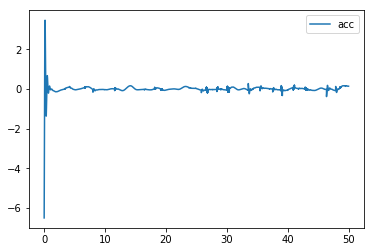

In [6]:
fig, ax = plt.subplots()
tdata = np.arange(0,num*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

# ax.plot(tdata,xvl,label="vel")

ax.legend()

Text(0.5, 1.0, 'xpos')

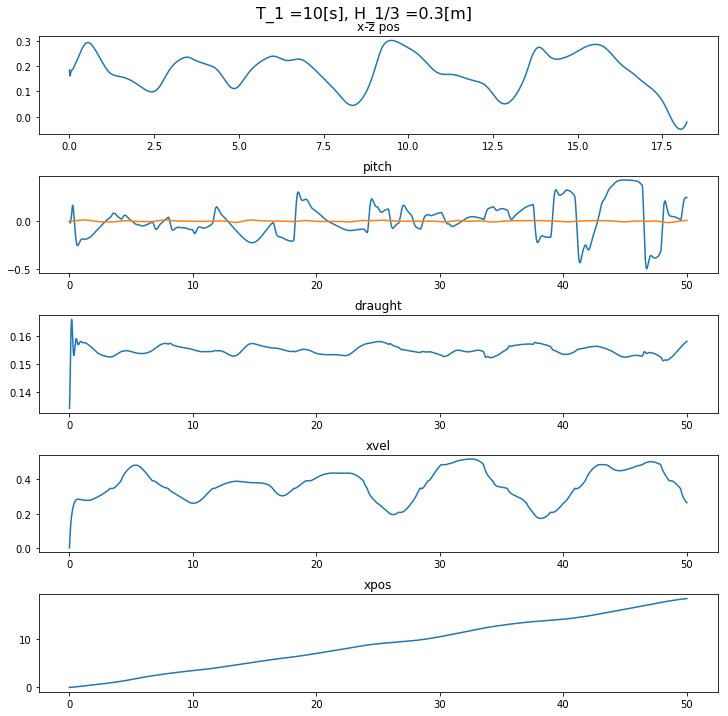

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5,figsize=(10,10),constrained_layout=True)

fig.suptitle( "T_1 =" + str(T_1) + "[s], H_1/3 =" + str(H_3) + "[m]", fontsize=16)


ax1.plot(xl,zl)
ax1.set_title('x-z pos')

ax2.plot(tdata,pl)
ax2.plot(tdata,wil)
ax2.set_title('pitch')

ax3.plot(tdata,dl)
ax3.set_title('draught')

ax4.plot(tdata,xvl)
ax4.set_title('xvel')

ax5.plot(tdata,xl)
ax5.set_title('xpos')

# fig.tight_layout()

In [8]:
import statistics
xvl_trunc = xvl[500:]
stdev = statistics.stdev(xvl_trunc)
mean = statistics.mean(xvl_trunc)

print(stdev,mean)
print(stdev/mean*100)

0.08795440279636191 0.3661261414673671
24.02297810362752


In [9]:
temp = [1,2,3,4,5,6,7,8,9]
temp[-1:]

[9]

In [10]:
force

18.8